# Time Series Forecasting with SARIMA Model

## Introduction

In this experiment, we will use the dataset of [Climate Change: Earth Surface Temperature Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data).

The dataset contains the global land and ocean temperature data from 1750 to 2015. The data is divided into 7 files, and I will mainly use the GlobalLandTemperaturesByCountry and City data.

The main practice on this dataset will be:
1. Data Preprocessing using **Polars** library
2. **Seasonal ARIMA (SARIMA)** model for time series forecasting


In [96]:
# library import
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import statsmodels.api as sm
import random
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


%matplotlib inline

import os
import re
import glob
import shutil
import gc
from pathlib import Path
import xlsxwriter

# showing module
from IPython.display import display

# output display option adjustment
# precision of floating point in numpy
np.set_printoptions(suppress=True, precision=4)

# precision of floating point in pandas
pd.options.display.float_format = '{:.4f}'.format

# display all columns in dataframe
pd.set_option("display.max_columns",None)

# default font size in graph
plt.rcParams["font.size"] = 14

# graph display
sns.set(rc={'figure.figsize':(12,5)})

# random seed
random_seed = 49

[Climate Change: Earth Surface Temperature Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data)

In [2]:
# create the input_dir（input directory）
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# if INPUT_DIR has not been created yet, create it
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# output_dir(output directory) creation
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# if OUTPUT_DIR has not been created yet, create it
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [3]:
# Once you run this code, comment it out
# move csv files to `data` directory(=folder)
# unique_dir_names = []
# for f in Path(f'{current_note_path}').rglob('*.csv'):
#     unique_dir_names.append(f)

# for file in list(set(unique_dir_names)):
#     print(f'moved file: {file}')
#     shutil.move(f'{file}', f'{INPUT_DIR}')

In [4]:
# Polars function to let us read csv files without having to specify the directory
def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + '.csv')
    print(f'Load: {path}')
    return pl.read_csv(path, **kwrgs)

In [5]:
df_state = read_csv("GlobalLandTemperaturesByState")
df_city = read_csv("GlobalLandTemperaturesByCity")

Load: /Users/satoshiido/Documents/programming/climate-change-analysis/data/GlobalLandTemperaturesByState.csv
Load: /Users/satoshiido/Documents/programming/climate-change-analysis/data/GlobalLandTemperaturesByCity.csv


In [6]:
def display_data_info(df_state, df_city):
    display(df_state.shape)
    display(df_city.shape)
    display(df_state.null_count())
    display(df_city.null_count())
    display(df_state[["Country", "AverageTemperature"]].group_by(["Country"]).mean().sort("AverageTemperature"))
    display(df_city[["Country", "AverageTemperature"]].group_by(["Country"]).mean().sort("AverageTemperature"))

display_data_info(df_state, df_city)

(645675, 5)

(8599212, 7)

dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
u32,u32,u32,u32,u32
0,25648,25648,0,0


dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
u32,u32,u32,u32,u32,u32,u32
0,364130,364130,0,0,0,0


Country,AverageTemperature
str,f64
"""Canada""",-1.321079
"""Russia""",1.808555
"""United States""",10.701555
"""China""",11.20683
"""Australia""",17.664222
"""India""",22.534576
"""Brazil""",23.770601


Country,AverageTemperature
str,f64
"""Mongolia""",-3.365485
"""Iceland""",1.500089
"""Russia""",3.347268
"""Norway""",3.612553
"""Finland""",3.711645
"""Kazakhstan""",4.3403
"""Estonia""",4.695705
"""Canada""",4.900387
"""Latvia""",5.386616


## Preprocessing

In [7]:
df_state = read_csv("GlobalLandTemperaturesByState")
df_city = read_csv("GlobalLandTemperaturesByCity")

Load: /Users/satoshiido/Documents/programming/climate-change-analysis/data/GlobalLandTemperaturesByState.csv
Load: /Users/satoshiido/Documents/programming/climate-change-analysis/data/GlobalLandTemperaturesByCity.csv


In [8]:
df_state = df_state.rename({"dt": "date", "AverageTemperature": "avg_temp", "AverageTemperatureUncertainty": "avg_temp_uncertainty", "State": "state", "Country": "country"})
df_city = df_city.rename({"dt": "date", "AverageTemperature": "avg_temp", "AverageTemperatureUncertainty": "avg_temp_uncertainty", "City":"city", "Country": "country"})

In [9]:
df_state = (df_state.with_columns(pl.col("date").str.strptime(pl.Datetime).set_sorted()))
df_city = (df_city.with_columns(pl.col("date").str.strptime(pl.Datetime).set_sorted()))

In [10]:
df_state = df_state.with_columns(pl.col("date").dt.year().alias("Year"))

In [11]:
# fill null values with the average temperature of the previous and next values
df_state = df_state.with_columns([
    pl.col("avg_temp").forward_fill().alias("ffill"),
    pl.col("avg_temp").backward_fill().alias("bfill")
])
avg_fill = (pl.col("ffill") + pl.col("bfill")) / 2
df_state = df_state.with_columns(avg_fill = (pl.col("ffill") + pl.col("bfill")) / 2)
df_state = df_state.with_columns(avg_temp = pl.when(pl.col("avg_temp").is_null()).then(pl.col("avg_fill")).otherwise(pl.col("avg_temp")))
df_state = df_state.drop(["ffill", "bfill", "avg_fill"])

In [12]:
# Exctract the data from 1970
latest_state = df_state.filter(pl.col("Year") > 1970)
latest_state.head()

date,avg_temp,avg_temp_uncertainty,state,country,Year
datetime[μs],f64,f64,str,str,i32
1971-01-01 00:00:00,25.842,0.266,"""Acre""","""Brazil""",1971
1971-02-01 00:00:00,25.325,0.42,"""Acre""","""Brazil""",1971
1971-03-01 00:00:00,25.866,0.164,"""Acre""","""Brazil""",1971
1971-04-01 00:00:00,25.312,0.191,"""Acre""","""Brazil""",1971
1971-05-01 00:00:00,24.859,0.547,"""Acre""","""Brazil""",1971


## Plotting

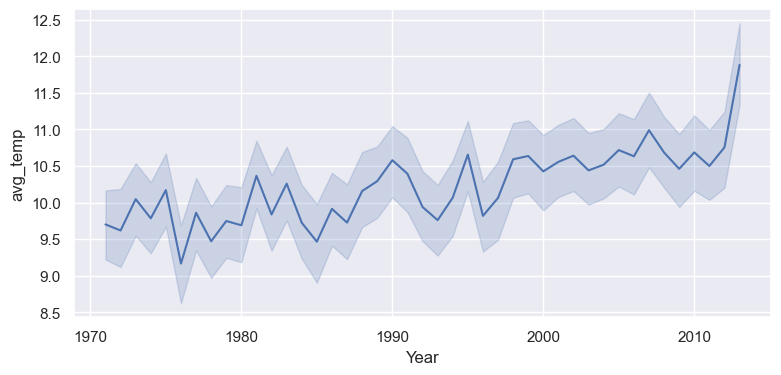

In [13]:
plt.figure(figsize=(9,4))
sns.lineplot(x="Year", y="avg_temp", data=latest_state)
plt.show()

## Special Mean and S.D

Rolling Mean and S.D. of Temperature and Exponentially Weighted Moving Average (EWMA)

In [14]:
# calculate the rolling average of the 2 months
## sort the data by date and set the sorted index to date
latest_state = latest_state.sort("date").set_sorted("date")

latest_state = latest_state.with_columns(
    # rolling average of 2 months
    rol_avg_temp_2 = pl.mean("avg_temp").rolling(index_column="date", period="2mo"),
    # exponentially weighted mean (EWMA) with a span of 3
    ewm_3 = pl.col("avg_temp").ewm_mean(span=3),
    # exponentially weighted standard deviation (EWMA) with a span of 3
    rol_std_3 = pl.col("avg_temp").ewm_std(span=3)
)

In [15]:
# calculate the year rolling (2months) average temperature
latest_state_by_year = latest_state.group_by("Year").agg(
    pl.col("avg_temp").mean().alias("avg_temp"),
    pl.col("rol_avg_temp_2").mean().alias("rol_avg_temp_2"),
    pl.col("ewm_3").mean().alias("ewm_3"),
    pl.col("rol_std_3").mean().alias("rol_std_3")
)
latest_state_by_year.head()

Year,avg_temp,rol_avg_temp_2,ewm_3,rol_std_3
i32,f64,f64,f64,f64
2009,10.461537,10.53052,10.461557,9.535212
1978,9.471348,9.525695,9.471387,9.531462
1971,9.70175,9.645251,9.706589,9.392597
2002,10.641713,10.69737,10.641368,9.352933
1990,10.579912,10.523052,10.580076,9.235876


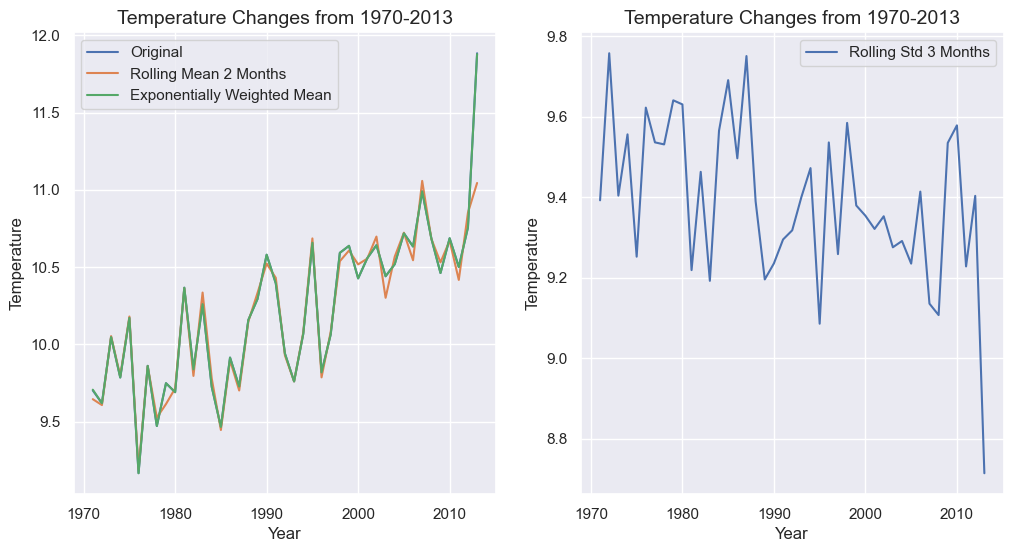

In [16]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
latest_state_by_year = latest_state_by_year.sort("Year")

# temperature graph with rolling mean and exponentially weighted moving mean
# df_state_byyear = latest_df_state.group_by("Year").agg(pl.col("avg_temp").mean())
ax1.plot(latest_state_by_year["Year"], latest_state_by_year["avg_temp"], label="Original")
ax1.plot(latest_state_by_year["Year"], latest_state_by_year["rol_avg_temp_2"], label="Rolling Mean 2 Months")
ax1.plot(latest_state_by_year["Year"], latest_state_by_year["ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Temperature Changes from 1970-2013", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 12)
ax1.set_ylabel("Temperature", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(latest_state_by_year["Year"], latest_state_by_year["rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Temperature Changes from 1970-2013", fontsize = 14)
ax2.set_xlabel("Year", fontsize = 12)
ax2.set_ylabel("Temperature", fontsize = 12)
ax2.legend()

## Time Series Modeling

I apply SARIMA model to the temperature data especially for the city of New York.

In [49]:
# preprocessing for the analysis
start_date = datetime(1900, 1, 1)
end_date = datetime(2013, 1, 1)

# filter the data for New York and select the date and average temperature
# Also, filter the data for the specified date range (1990-2012)
ny = df_city.filter((pl.col("city") == "New York")
    ).select(pl.col("date"), pl.col("avg_temp").alias("Temp")
    ).filter((pl.col("date") >= start_date) & (pl.col("date") < end_date))

# change theb data frqeuency to monthly and fill the null values with the previous value
ny = ny.upsample(
    time_column="date", every="1mo", maintain_order=True
    ).with_columns((pl.col("Temp").backward_fill(limit=1)))

ny.head()

date,Temp
datetime[μs],f64
1900-01-01 00:00:00,-2.214
1900-02-01 00:00:00,-2.477
1900-03-01 00:00:00,-0.07
1900-04-01 00:00:00,9.069
1900-05-01 00:00:00,14.919


In the following section, I'll provide a concise overview of ARIMA models:

# <font color=lightblue>SARIMA Model (p, d, q)(P, D, Q, S)</font>:
SARIMA is an acronym for Seasonal AutoRegressive Integrated Moving Average. Despite its intimidating name, the concept is more approachable than it first appears.

## <font color=lightblue>Non-Seasonal ARIMA (p, d, q)</font>:

The term ARIMA is divided into three components: AR, I, and MA:

- **AR(p)**: This stands for the *autoregressive* part, where `p` is an integer indicating the count of lagged observations included in the model. For instance:
    - The average temperature from the previous day greatly influences today's temperature; hence we use AR(1) to predict future temperatures.
    - The AR(p) model is represented by the equation: $\hat{y}_{t} = \mu + \theta_{1}Y_{t-1} + ... + \theta_{p}Y_{t-p}$, where $\mu$ is a constant, **p** denotes the number of lag periods, and $\theta$ represents the fitted parameter.

- **I(d)**: This represents the *differencing* step, with `d` indicating the number of differencing operations applied to achieve stationarity. For example:
    - If we sold 10 items yesterday and 14 today, the first difference (I) is +4. If using logs, this signifies a percentage change.
    - For d = 1: $y_{t} = Y_{t} - Y_{t-1}$
    - For d = 2: $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-1} - Y_{t-2})$
    - The second difference evaluates the rate of change, providing insight into acceleration rather than just trend.

- **MA(q)**: This refers to the *moving average* component, where `q` is the number of lagged forecast errors in the prediction equation. For example:
    - The MA term incorporates a fraction of past forecasting errors, postulating that these errors will recur in future forecasts.
    - The MA(q) model is defined as: $\hat{y}_{t} = \mu - \Theta_{1}e_{t-1} + ... + \Theta_{q}e_{t-q}$, where $\mu$ is the constant, **q** refers to the lag period for the error term $e$, and $\Theta$ is the parameter fitted to these errors.
    - The error term is calculated by $ e_{t} = Y_{t-1} - \hat{y}_{t-1}$.


# <font color=lightblue>Seasonal ARIMA (p, d, q)(P, D, Q, S)</font>:

The seasonal parameters **P, D, Q** are capitalized to differentiate them from the non-seasonal parameters.

- **SAR(P)**: This is the seasonal autoregressive term.
    - The SAR(P) model equation is: $\hat{y}_{t} = \mu + \theta_{1}Y_{t-s}$, where P is the number of autoregressive terms included, s denotes the seasonal lag, and $\theta$ is the parameter fitted to the data.
    - In weather forecasting, data from 12 months prior can be informative for the current period.
    - Opting for SAR(1) incorporates a factor of $Y_{t-s}$ into the forecast for $y_{t}$.

- **I(D)**: Seasonal differencing is essential when there's a pronounced, consistent pattern.
    - With d = 0 and D = 1: $y_{t} = Y_{t} - Y_{t-s}$
    - With d = 1 and D = 1: $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-s} - Y_{t-s-1})$
    - D should not exceed 1, and the sum of d+D should not be more than 2. If d+D equals 2, the constant term is typically omitted.

- **SMA(Q)**: 
    - Setting Q=1, for example as SMA(1), incorporates a multiple of the error term $e_{t-s}$ into the forecast for $y_{t}$.

- **S**: This denotes the seasonal period for calculating P, D, Q. For instance, a 52-week seasonal pattern would be represented by 'S'.

# <font color=lightblue>Trend (p, d, q)(P, D, Q, S)</font>:

To predict trends, we use [SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). The following notations define the trend components:

- 'n' implies no trend (default).
- 'c' signifies a constant term in the model.
- 't' stands for a linear trend over time.
- 'ct' combines both a constant and a linear trend.
- A custom polynomial trend can also be specified, akin to `numpy.poly1d`, for example, [1,1,0,1] would denote a trend of the form a+bt+ct³.

Briefly check the variation of temperature in New York from 1900 to 2012.

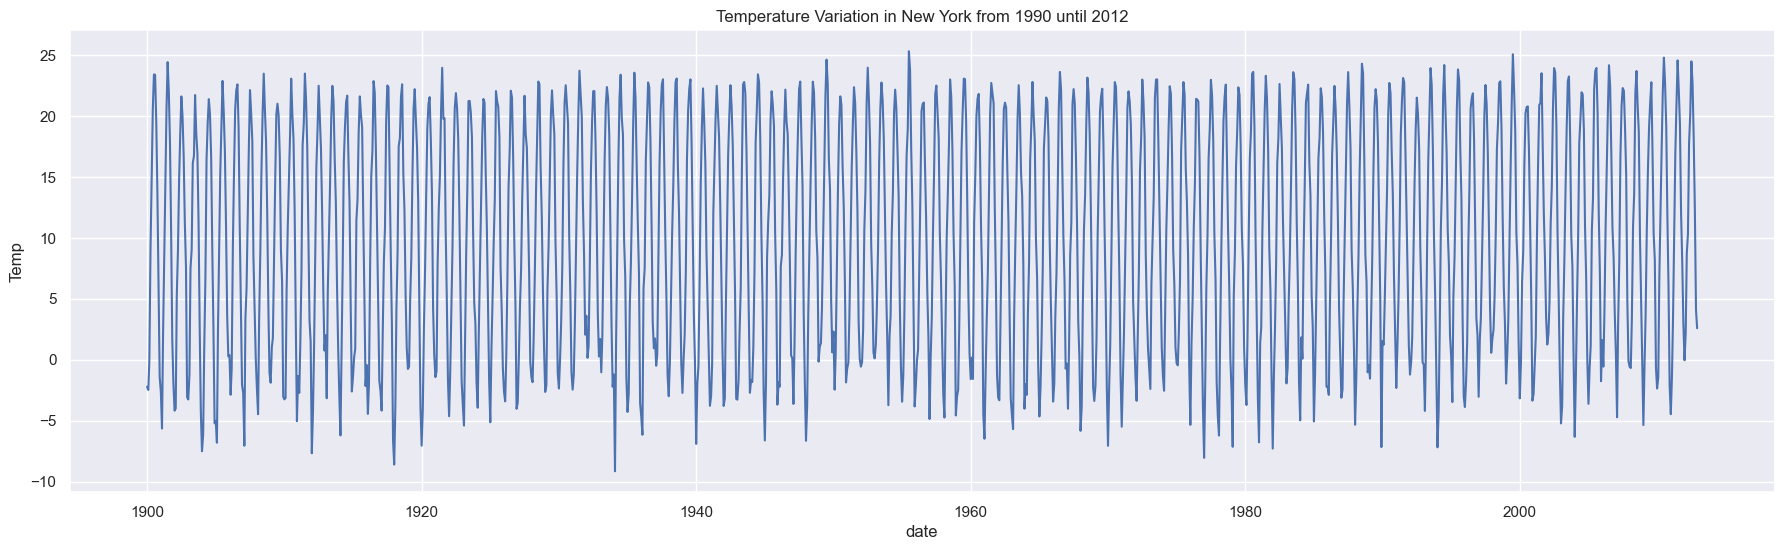

In [67]:
plt.figure(figsize=(22,6))
sns.lineplot(data=ny,
             x="date", y="Temp").set(title="Temperature Variation in New York from 1990 until 2012")
plt.show()

From these plots, we can see that the temperature has some seasonality. From February to August, the temperature goes up and goes down from August to February. 

The temperature also potentially has an increasing trend over time.

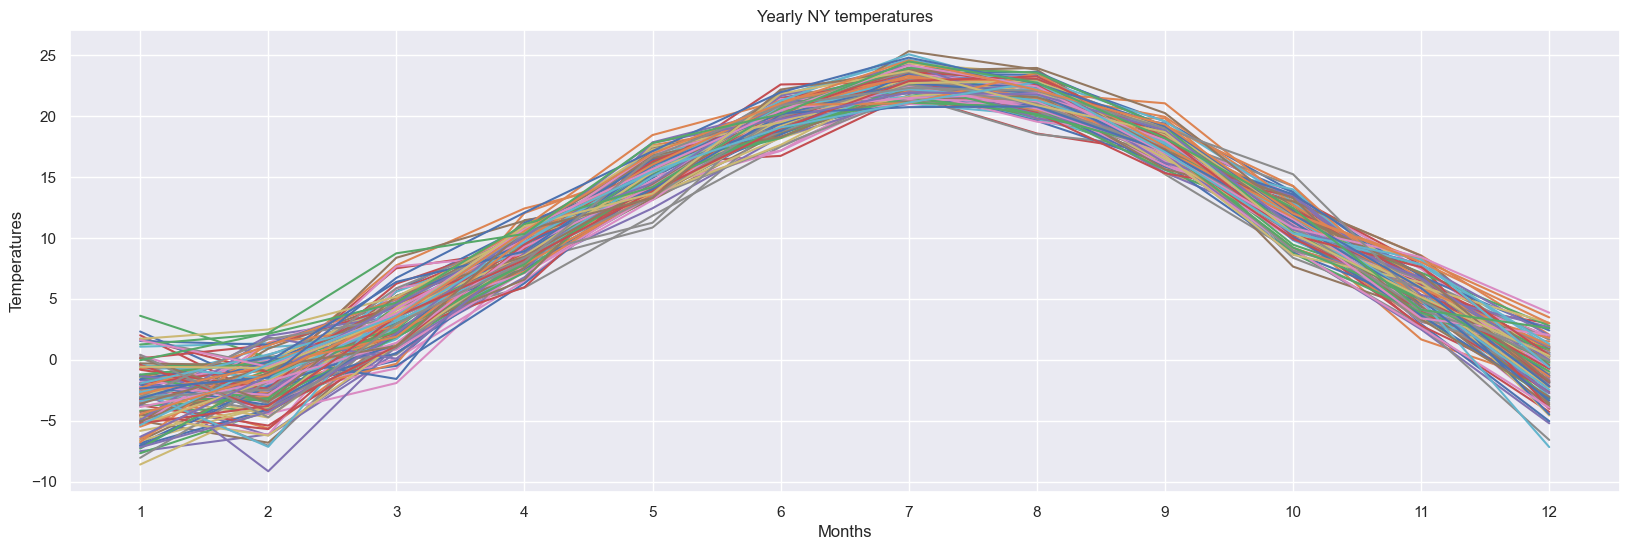

In [59]:
ny = ny.with_columns(pl.col("date").dt.month().alias("month"), pl.col("date").dt.year().alias("year"))
pivot_ny = ny.pivot(index="month", columns="year", values="Temp", aggregate_function="mean")
pivot_ny_pd = pivot_ny.to_pandas()
pivot_ny_pd.plot(x='month', figsize=(20,6))
plt.title('Yearly NY temperatures')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()

We can now check if there is some trend through the years in this Series

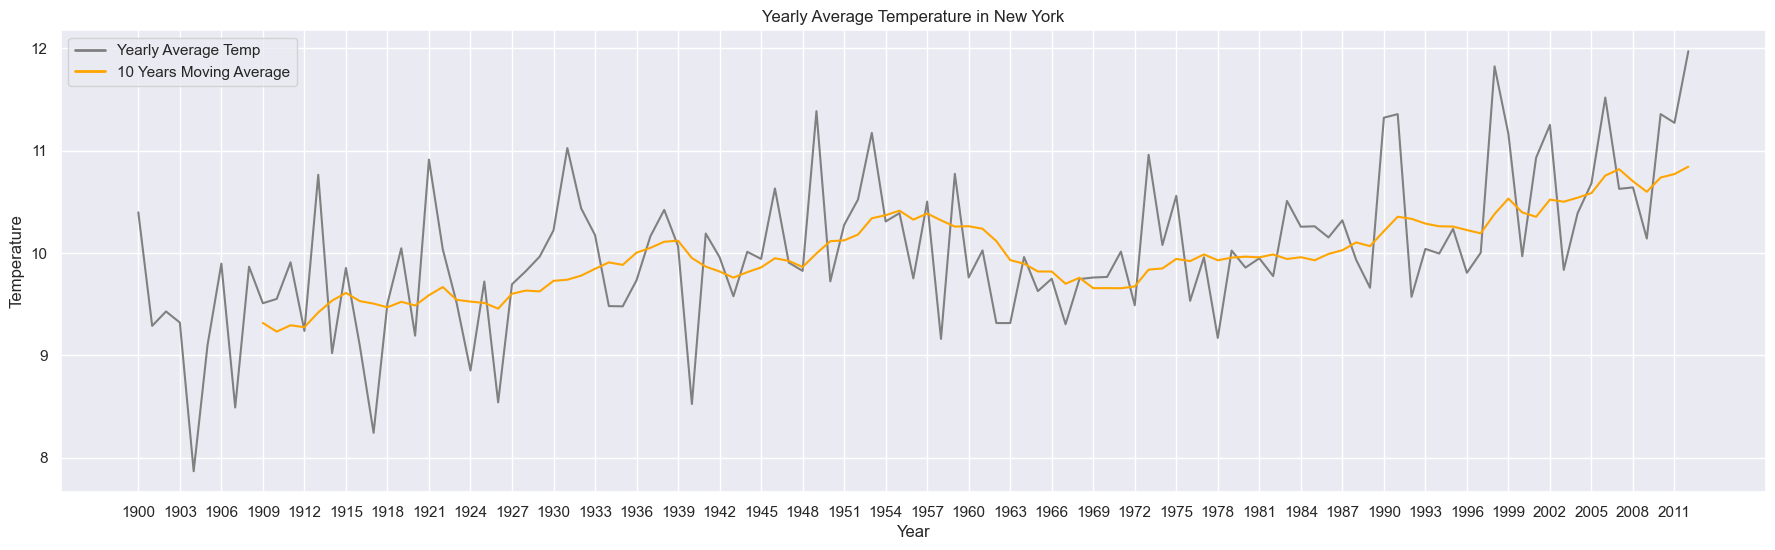

In [83]:
from matplotlib.lines import Line2D
ny_year_avg = ny.group_by("year").agg(pl.col("Temp").mean()).sort("year")
ny_year_avg = ny_year_avg.with_columns(pl.col("Temp").rolling_mean(window_size=10).alias("10 Years MA"))

# plot the yearly average temperature and the 10 years moving average
plt.figure(figsize=(22,6))

line1 = sns.lineplot(data=ny_year_avg, x="year", y="Temp", color="grey")
line2 = sns.lineplot(data=ny_year_avg, x="year", y="10 Years MA", color="orange")
line2.get_lines()[0]
plt.title("Yearly Average Temperature in New York")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.xticks([x for x in range(1900,2012,3)])
# plt.legend(['Yearly Average Temp', '10 Years Moving Average'])
legend_elements = [Line2D([0], [0], color='grey', lw=2, label='Yearly Average Temp'),
                   Line2D([0], [0], color='orange', lw=2, label='10 Years Moving Average')]
plt.legend(handles=legend_elements)

### Data Split

Before proceeding, I will split the data into training, validation and test sets. After training the model, I will use the last 5 years for validation and testing, with 48 months for month-by-month [walk-forward validation](https://alphascientist.com/walk_forward_model_building.html) and 12 months for future extrapolation to compare against the test set.

In [107]:
train = ny[:-60].clone()
val = ny[-60:-12].clone()
test = ny[-12:].clone()
train.shape, val.shape, test.shape

((1296, 4), (48, 4), (12, 4))

And before creating the forecasts we will create a baseline forecast in the validation set, in our simulation we will try to have a smaller error compared to this one.

it will hold the previous month as a base forecast to the next month:

In [28]:
# fill the first row of the validation with average temeprature of January in the five year before
jan_avg_temp = train.filter(pl.col("month") == 1).tail().mean().select(pl.col("Temp"))

baseline = val['Temp'].shift(fill_value=jan_avg_temp.item())
# baseline.dropna(inplace=True)
baseline.head()

Temp
f64
-1.6978
-0.675
3.47
10.943
13.64
21.831
23.693
20.887
18.676


We create a function to use the [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) as a base to calculate the error of the forecast.

In [29]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Using the function with the baseline values
rmse_base = measure_rmse(val.select(pl.col("Temp")), baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 5.0244 celsius degrees


Observing the data, it's evident that the series exhibits a slight upward trend, coupled with a seasonal pattern where temperatures dip at the start and end of the year and peak during the mid-year months.

To forecast a time series effectively, the data needs to be stationary, meaning it should have a stable mean, variance, and autocorrelation over time.

Stationarity of the series can be tested with the **adfuller function**. A P-Value below 5% from this test indicates that the series is stationary, allowing us to proceed with model development.

For non-stationary series, transformations such as taking the natural log, deflation, or differencing may be applied to achieve stationarity.

The following function is designed to assess stationarity, and it provides visualizations of:

 * The time series;
 * The autocorrelation function **(ACF)**:
      * This function displays the relationship between current temperatures and their past values.
 * The partial autocorrelation **(PACF)**:
     * This function illustrates the direct correlation between current temperatures and past values, eliminating the influence of intermediate lags. For instance, it would isolate the impact of lag 3 on current temperatures, disregarding the influence of lags 1 and 2.

For further reading and in-depth materials on the subject, Mr. Robert Nau's website at [ Duke University](http://people.duke.edu/~rnau/411home.htm) comes highly recommended. Additionally, [Jason Brownlee's](machinelearningmastery.com) website is a valuable resource for time series analysis content.

### Check Stationarity
Before proceeding with the SARIMA model, we will check the stationarity of the series and apply the necessary transformations to achieve stationarity.
Unfortunatelly, I can't find compatibile `statsmodels` library for Polars dataframe. So I convert the dataframe to pandas dataframe and then use acf and pacf functions to check the stationarity of the series.

In [30]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the df
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title("New York Temperature Variation in 1990-2012")
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.histplot(y, bins=int(sqrt(len(y))), ax=ax4)
    # sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                  -5.0980
p-value                          0.0000
Lags Used                       23.0000
Number of Observations Used   1272.0000
Critical Value (1%)             -3.4355
Critical Value (5%)             -2.8638
Critical Value (10%)            -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


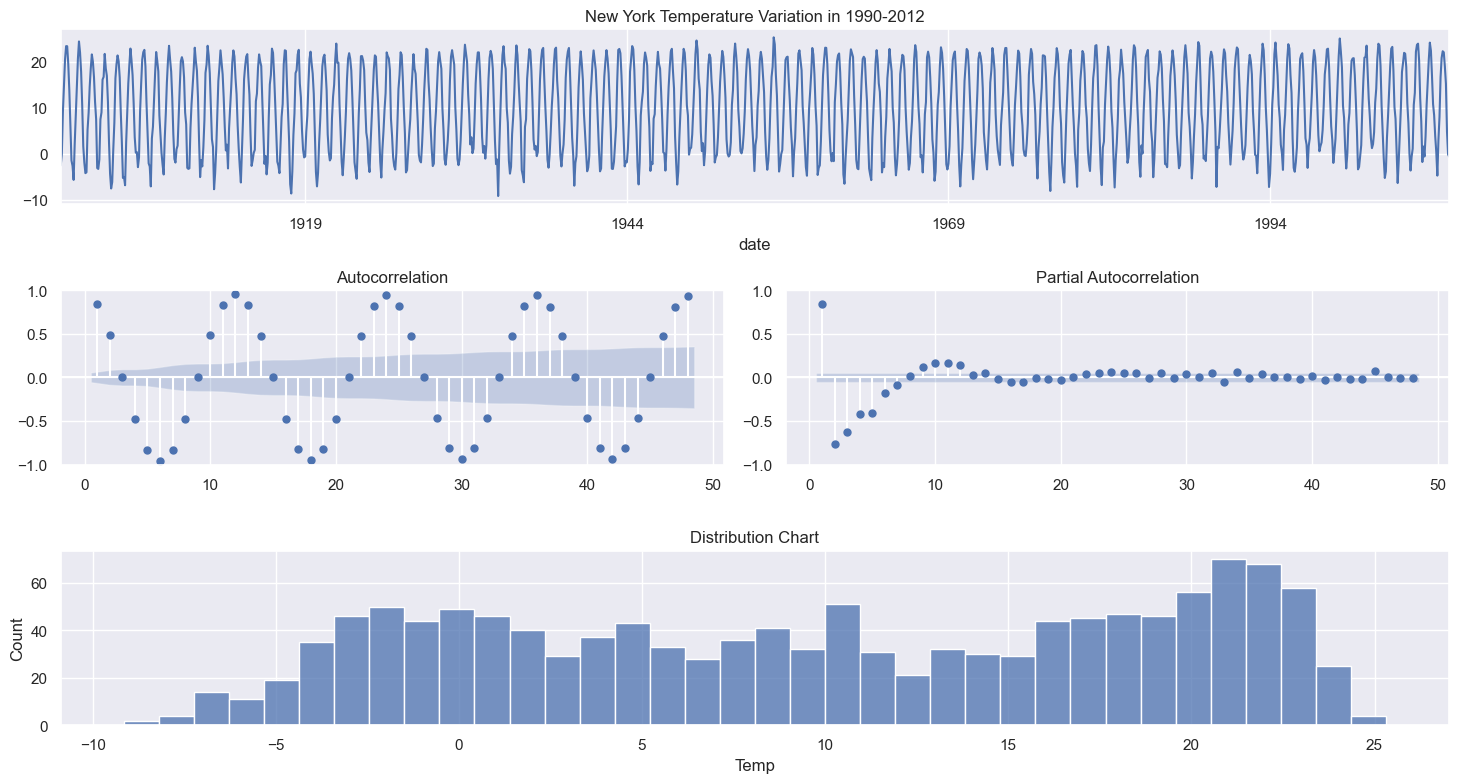

In [32]:
# The first approach is to check the series without any transformation
# convert the Polars to Pandas
# set the index to the "date" column
# resample to a monthly frequency, using backward filling
tmp = train.to_pandas().set_index("date").asfreq('M', method='bfill')["Temp"]

check_stationarity(tmp)

The time series displays an interesting pattern. There is a statistically significant negative autocorrelation at lag 6 that repeats every 12 months. This is likely due to seasonal differences, as today's winter temperatures tend to be negatively correlated with temperatures 6 months from now in the summer. The autocorrelogram also shows significant positive autocorrelation at lag 12 and subsequent lags spaced 12 months apart. The partial autocorrelation function has a positive spike at lag 1 followed by negative partial autocorrelations. 

The alternating pattern of autocorrelation and partial autocorrelation suggests an AR(1) model along with seasonal differencing at a lag of 12 months ($Y_{t} - Y_{t-12}$). Plotting the stationarity test on the seasonally differenced series will indicate if SAR(P) or SMA(Q) terms are also needed in the model.

Results of Dickey-Fuller Test:
Test Statistic                 -13.2348
p-value                          0.0000
Lags Used                       23.0000
Number of Observations Used   1260.0000
Critical Value (1%)             -3.4356
Critical Value (5%)             -2.8638
Critical Value (10%)            -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


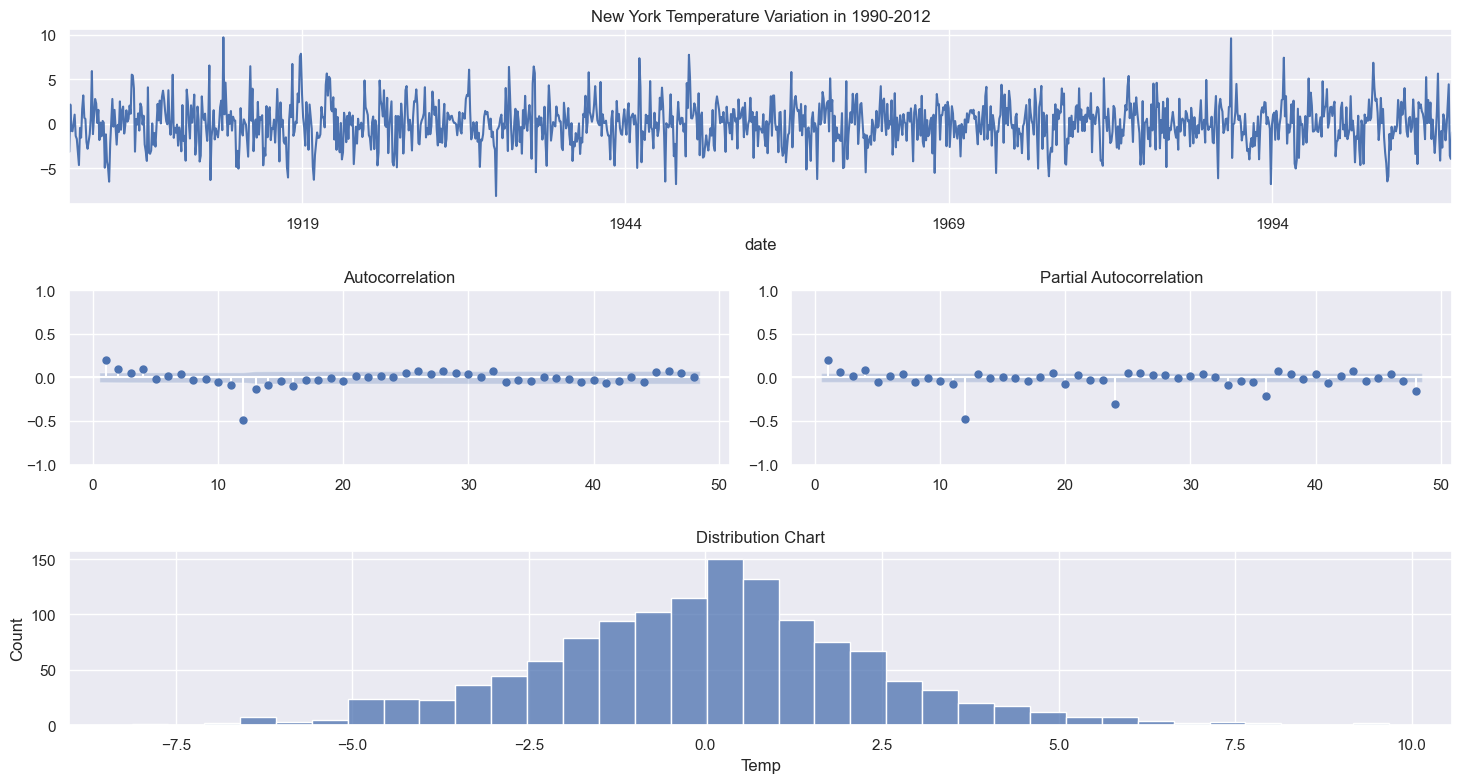

In [34]:
check_stationarity(tmp.diff(12).dropna())

The preceding graphs illustrate that the initial autocorrelation function (ACF) lags exhibit a gradual decrease, while the partial autocorrelation function (PACF) falls below the confidence threshold after the third lag. These characteristics suggest an autoregressive (AR) pattern with three lags, indicative of an AR(3) model.

Upon implementing a first seasonal differencing, both ACF and PACF reveal a pronounced decline at the 12th lag, indicating a single-lag seasonal moving average (SMA) pattern. In summary, this points to a seasonal AR model of the first order with one differencing, or SAR(1) with a first difference.

For my initial analysis, I'll consider the following non-seasonal orders: (3, 0, 0), and for the seasonal components, I'll use (0,1,1,12). Given the series exhibits a clear upward trend, I will incorporate this into the model with a constant term ('c').

To begin projections for the validation set, I will devise a function that applies a one-step-ahead forecast across the entire validation set and calculates the forecast error.

In [93]:
train.select(pl.col("Temp")).to_numpy()

array([[-2.214],
       [-2.477],
       [-0.07 ],
       ...,
       [ 4.831],
       [-0.094],
       [-0.573]])

In [94]:
def walk_forward(training, validation, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    # Transforming the Polars to Numpy
    history = [x for x in training.to_numpy()]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    # Forecasting one period ahead in the validation set
    for week in range(len(validation)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation[week])
        
    return prediction

In [99]:
val

date,Temp,month,year
datetime[μs],f64,u32,i32
2008-02-01 00:00:00,-0.675,2,2008
2008-03-01 00:00:00,3.47,3,2008
2008-04-01 00:00:00,10.943,4,2008
2008-05-01 00:00:00,13.64,5,2008
2008-06-01 00:00:00,21.831,6,2008
2008-07-01 00:00:00,23.693,7,2008
2008-08-01 00:00:00,20.887,8,2008
2008-09-01 00:00:00,18.676,9,2008
2008-10-01 00:00:00,10.348,10,2008


In [103]:
val

date,Temp,month,year
datetime[μs],f64,u32,i32
2008-02-01 00:00:00,-0.675,2,2008
2008-03-01 00:00:00,3.47,3,2008
2008-04-01 00:00:00,10.943,4,2008
2008-05-01 00:00:00,13.64,5,2008
2008-06-01 00:00:00,21.831,6,2008
2008-07-01 00:00:00,23.693,7,2008
2008-08-01 00:00:00,20.887,8,2008
2008-09-01 00:00:00,18.676,9,2008
2008-10-01 00:00:00,10.348,10,2008


In [104]:
# Test it in the validation set
predictions = walk_forward(train['Temp'], val['Temp'], ((3,0,0),(0,1,1,12),'c'))
val = val.with_columns(pl.Series(name="Pred", values=predictions))

In [108]:
val = val.with_columns(pl.Series(name="Pred", values=predictions))

In [110]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was 4.6434 celsius degrees
It's a decrease of -7.58% in the RMSE


In [113]:
# Creating the error column
val = val.with_columns((pl.col("Temp") - pl.col("Pred")).alias("Error"))

In [114]:
val

date,Temp,month,year,Pred,Error
datetime[μs],f64,u32,i32,f64,f64
2008-01-01 00:00:00,-0.573,1,2008,-1.044053,0.471053
2008-02-01 00:00:00,-0.675,2,2008,3.77589,-4.45089
2008-03-01 00:00:00,3.47,3,2008,9.632501,-6.162501
2008-04-01 00:00:00,10.943,4,2008,15.803873,-4.860873
2008-05-01 00:00:00,13.64,5,2008,20.173569,-6.533569
2008-06-01 00:00:00,21.831,6,2008,23.224291,-1.393291
2008-07-01 00:00:00,23.693,7,2008,22.332068,1.360932
2008-08-01 00:00:00,20.887,8,2008,17.92273,2.96427
2008-09-01 00:00:00,18.676,9,2008,11.713698,6.962302
